# Convolutional Neural Networks: Step by Step

- Convolution 레이어와 Pooling 레이어를 구축
- Forward & Backward Propagation

**Notation**:
- 윗첨자 $[l]$ 은 $l$ 번째 레이어
    - $a^{[4]}$ 는 $4$번째 활성(activation) 함수.
    - $W^{[5]}$ 과 $b^{[5]}$ 은 $5$번째 레이어의 매개변수


- 아래첨자 $(i)$ 는 $i$ 번째 자료
    - $x^{(i)}$ 은 $i$ 번째 훈련 자료
    
    
- 아래첨자 $i$는 $i$번째 벡터의 entry
    - $a^{[l]}_i$ 은 $i$번째 entry, $l$번재 레이어의 활성함수
    
    
- $n_H$, $n_W$, $n_C$는 각각의 레이어에서 높이, 너비, 채널번호
    - $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$ 은 $l$번째 레이어에서의 높이, 너비, 채널번호


- $n_{H_{prev}}$, $n_{W_{prev}}$, $n_{C_{prev}}$은 이전 레이어의 높이, 너비, 채널번호
    - $l$번째 레이어를 기준으로는, $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$으로 쓸 수 있음

## 1 - Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

## 2 - 코드 개요

Convolution 신경망의 블록을 구현합니다. 구체적으로는 아래와 같은 코딩을 step-by-step으로 수행합니다.

- Convolution functions:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward
    
- Pooling functions, including:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward (optional)
    
<img src="images/model.png" style="width:800px;height:280px;">

## 3 - Convolutional Neural Networks

- Convolution 레이어는 일반적으로 가로세로는 축소되고 채널의 크기가 커지게 합니다

<img src="images/conv_nn.png" style="width:650px;height:350px;">

### 3.1 - Zero-Padding

Zero-padding은 이미지 테두리에 0을 추가하는 방법입니다

<img src="images/PAD.png" style="width:800px;height:600px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>Zero-Padding</b><br> Image (3 channels, RGB) with a padding of 2. </center></caption>

패딩을 하는 이유:
    
- 네트워크를 깊게(deep)하게 만듬에 따라 반드시 높이/너비가 줄어들기 때문에 높이와 너비를 축소시키지 않고도 CONV 레이어를 사용할 수 있습니다.
- 패딩이 없으면 다음 레이어에서 가장자리에 있는 픽셀의 정보를 잃게 됩니다.

**Exercise**
- [np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html) 함수를 활용합니다.
- $(5,5,5,5,5)$의 shape를 갖는 배열에 2번째 차원에 1개, 4번째 차원에 3개의 zero 패드를 추가하고 싶다면 아래와 같이 사용합니다.
```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), mode='constant', constant_values = (0,0))
```

In [3]:
def zero_pad(X, pad):
    """
    Argument:
    X -- (m, n_H, n_W, n_C)의 차원을 갖는 numpy 배열 (m개의 이미지)
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=0)
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)


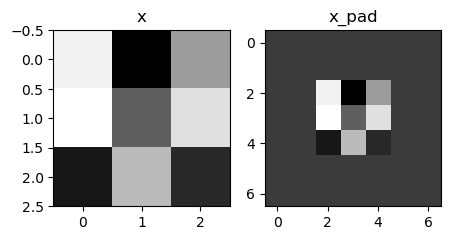

In [4]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)

fig, ax = plt.subplots(1, 2)
ax[0].set_title('x')
ax[0].imshow(x[0,:,:,0])
ax[1].set_title('x_pad')
ax[1].imshow(x_pad[0,:,:,0]);

### 3.2 - Single step of convolution 

Filter를 사용하여 1회의 Convolution을 수행함

- 입력자료의 volume을 계산하고
- 각 포지션마다 filter를 적용하고
- 다른 volume을 가진 출력자료를 생성함

<img src="images/Convolution_schematic.gif" style="width:500px;height:350px;">
<caption><center> <u> <font color='purple'> <b>Figure 2</b> </u><font color='purple'>  : <b>Convolution operation</b><br>
    3x3의 필터 (stride=1, stride는 filter가 이동하는 간격) </center></caption>


- 왼쪽 행렬의 각 값은 픽셀 값에 해당하며 요소별로 filter값을 곱하고 bias를 추가하여 Convolution함
- 최초 코딩단계에서는 단일 값 출력을 얻기 위해 위치 중 하나에만 filter를 적용하는 코드를 구현

**Exercise**: conv_single_step() 를 구현. [Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.sum.html).

In [5]:
def conv_single_step(a_slice_prev, W, b):
    """
    Arguments:
    a_slice_prev -- (f, f, n_C_prev) shape를 갖는 입력자료의 일부 슬라이스
    W -- Filter의 가중치(weight) 매개변수로 (f, f, n_C_prev) shape
    b -- Filter의 편의(bias) 매개변수로 (1, 1, 1) shape
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """

    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s = np.multiply(a_slice_prev, W)
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = Z + b

    return Z

In [6]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = [[[-6.99908945]]]


### 3.3 - Convolutional Neural Networks - Forward pass


<center>
<video width="900" height="600" src="images/conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>

**Exercise**: 
Filter의 매개변수 `W`와 이전 레이어의 출력인 `A_prev`를 가지고 convolution 함수 작성

* `A_prev`는 이전 레이어의 활성함수로부터의 출력(m개의 미니배치 개수를 갖는 입력자료); 
* 가중치 매개변수는 `W`.
* Filter의 윈도우 사이즈는 `f`
* bias는 `b`이고 각 filter는 하나의 값으로 통일됨

**Hint**: 
1. To select a 2x2 slice at the upper left corner of a matrix "a_prev" (shape (5,5,3)), you would do:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
Notice how this gives a 3D slice that has height 2, width 2, and depth 3.  Depth is the number of channels.  
This will be useful when you will define `a_slice_prev` below, using the `start/end` indexes you will define.
2. To define a_slice you will need to first define its corners `vert_start`, `vert_end`, `horiz_start` and `horiz_end`. This figure may be helpful for you to find out how each of the corner can be defined using h, w, f and s in the code below.

<img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">
<caption><center> <u> <font color='purple'> <b>Figure 3</b> </u><font color='purple'>  : <b>Definition of a slice using vertical and horizontal start/end (with a 2x2 filter)</b> <br> This figure shows only a single channel.  </center></caption>

**Reminder**:
입력자료의 shape, filter의 사이즈 f, stride에 따른 출력자료 shape는 아래의 공식과 같이 결정됨:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

In [7]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Arguments:
    A_prev -- 이전 레이어의 numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- 가중치, numpy array of shape (f, f, n_C_prev, n_C)
    b -- 편의, numpy array of shape (1, 1, 1, n_C)
    hparameters -- "stride" 와 "pad" 매개변수를 넣어둔 dict
        
    Returns:
    Z -- Convolution 결과 numpy array of shape (m, n_H, n_W, n_C)
    cache -- backward propagation을 위한 cache values
    """
    
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    # Hint: use int() to apply the 'floor' operation. (≈2 lines)
    n_H = int((n_H_prev-f+2*pad)/stride + 1)
    n_W = int((n_W_prev-f+2*pad)/stride + 1)
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                  # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]      # Select ith training example's padded activation
        for h in range(n_H):            # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = h * stride
            vert_end = h * stride + f
            
            for w in range(n_W):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice" (≈2 lines)
                horiz_start = w * stride
                horiz_end = w * stride + f
                
                for c in range(n_C):   # loop over channels (= #filters) of the output volume
                                        
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈3 line)
                    weights = W[..., c]
                    biases = b[..., c]
                    # print(a_slice_prev.shape, weights.shape, biases.shape)
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)

                                        
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

## 4 - Pooling layer 

Pooling layer는 높이와 너비를 축소시켜 계산 리소스를 줄일 수 있고 특징을 유지할 수 있습니다.

- Max-pooling layer:  ($f, f$)의 윈도우를 움직이면서 최대값을 취합니다.
- Average-pooling layer: ($f, f$)의 윈도우를 움직이면서 평균값을 취합니다.

<table>
<td>
<img src="images/max_pool1.png" style="width:500px;height:280px;">
<td>

<td>
<img src="images/a_pool.png" style="width:500px;height:280px;">
<td>
</table>

Pooling layer에는 학습을 위한 역전파 매개변수는 없지만 $f$와 같은 창 크기의 hyperparameter가 존재함

### 4.1 - Forward Pooling

**Exercise**: Max-pooling과 Average-pooling을 구현합니다

**Reminder**:
Padding이 없기 때문에 pooling layer의 출력 차원은 아래의 공식과 같습니다

$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$

$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$

$$ n_C = n_{C_{prev}}$$

In [9]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Arguments:
    A_prev -- 입력자료, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- "f" 와 "stride"를 넣어둔 dictionary
    mode -- Pooling 방법으로 문자열 "max" 또는 "average"
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                            # loop over the training examples
        for h in range(n_H):                      # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = h * stride
            vert_end = h * stride + f
            
            for w in range(n_W):                  # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current "slice" (≈2 lines)
                horiz_start = w * stride
                horiz_end = w * stride + f
                
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # Compute the pooling operation on the slice. 
                    # Use an if statement to differentiate the modes. 
                    # Use np.max and np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache